## Dependencies

In [1]:
import warnings, json, re, math
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Model parameters

In [2]:
config = {
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'N_FOLDS': 5, 'N_USED_FOLDS': 5, 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(f"/kaggle/input/{config['DATASET_PATH']}/train.csv")
train_ext = pd.read_csv(f"/kaggle/input/isic2019-256x256/train.csv")
train_malig_1 = pd.read_csv(f"/kaggle/input/malignant-v2-256x256/train_malig_1.csv")
# train_malig_2 = pd.read_csv(f"/kaggle/input/malignant-v2-256x256/train_malig_2.csv")
train_malig_3 = pd.read_csv(f"/kaggle/input/malignant-v2-256x256/train_malig_3.csv")
train['external'] = 0
train_ext['external'] = 1
train_malig_1['external'] = 0
train_malig_3['external'] = 0
train = pd.concat([train, train_ext, train_malig_1, train_malig_3])

test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 61853


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code,external
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0.0,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1.0,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2.0,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3.0,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4.0,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [4]:
display(train.describe())

,age_approx,target,tfrecord,width,height,patient_code,external
count,61275.000000,61853.000000,61853.000000,61853.000000,61853.000000,33710.000000,61853.000000
mean,51.555528,0.137455,11.685432,2579.533151,1798.705689,739.146544,0.409536
std,16.376824,0.344330,10.434983,2218.072246,1434.438340,530.738720,0.491752
min,0.000000,0.000000,-1.000000,576.000000,450.000000,0.000000,0.000000
25%,40.000000,0.000000,4.000000,824.000000,640.000000,275.000000,0.000000
50%,50.000000,0.000000,9.000000,1024.000000,1024.000000,663.000000,0.000000
75%,65.000000,0.000000,14.000000,5184.000000,3456.000000,1115.000000,1.000000
max,90.000000,1.000000,59.000000,6000.000000,6000.000000,2055.000000,1.000000


# Missing values

In [5]:
# age_approx (mean)
train['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
test['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
# anatom_site_general_challenge (NaN)
train['anatom_site_general_challenge'].fillna('NaN', inplace=True)
test['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# sex (mode)
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(train['sex'].mode()[0], inplace=True)

# Feature engineering

In [6]:
### Label ecoding
enc = LabelEncoder()
train['sex_enc'] = enc.fit_transform(train['sex'].astype('str'))
test['sex_enc'] = enc.transform(test['sex'].astype('str'))

### One-hot ecoding
# train = pd.concat([train, pd.get_dummies(train['sex'], prefix='sex_enc', drop_first=True)], axis=1)
# test = pd.concat([test, pd.get_dummies(test['sex'], prefix='sex_enc', drop_first=True)], axis=1)

### Mean ecoding
# Sex
train['sex_mean'] = train['sex'].map(train.groupby(['sex'])['target'].mean())
test['sex_mean'] = test['sex'].map(train.groupby(['sex'])['target'].mean())


# # External features
# train_img_ft = pd.read_csv('../input/landscape/TrainSuperTab.csv')
# test_img_ft = pd.read_csv('../input/landscape/TestSuperTab.csv')
# ext_fts = ['V1', 'V2', 'V3', 'V4','V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 
#            'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
#            'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
# for ft in ext_fts:
#     train[ft] = train_img_ft[ft]
#     test[ft] = test_img_ft[ft]

print('Train set')
display(train.head())
print('Test set')
display(test.head())

Train set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code,external,sex_enc,sex_mean
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0.0,0,1,0.147700
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1.0,0,0,0.122992
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2.0,0,0,0.122992
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3.0,0,0,0.122992
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4.0,0,0,0.122992


Test set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,sex_mean
0,ISIC_0052060,IP_3579794,male,70.0,NaN,1,0.147700
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,0.147700
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,0.122992
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,0.122992
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,0.122992


# Model

In [7]:
features = ['age_approx', 'sex_mean']

ohe_features  = [col for col in train.columns if 'enc' in col]

features += ohe_features

# External features
# features += ext_fts
print(features)

['age_approx', 'sex_mean', 'sex_enc']


In [8]:
# Hyperparameter grid
param_grid = {
    'max_depth': list(range(2, 10)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.3, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'scale_pos_weight': list(np.linspace(1, (len(train[train['target'] == 0]) / len(train[train['target'] == 1])), 10)),
}


skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)

def get_idxs():
    for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
        x_train = train[(train['tfrecord'].isin(idxT) & (train['external'] == 0)) |      # 2020 data
                        (train['tfrecord'].isin(idxT * 2) & (train['external'] == 1)) |  # 2018 data
                        (train['tfrecord'].isin(idxT + 30) & (train['external'] == 0)) | # 2019 & 2018 data (malig)
                        (train['tfrecord'].isin(idxT + 15) & (train['external'] == 0))   # new data  (malig)
                       ]
        x_valid = train[~((train['tfrecord'].isin(idxT) & (train['external'] == 0)) |      # 2020 data
                          (train['tfrecord'].isin(idxT * 2) & (train['external'] == 1)) |  # 2018 data
                          (train['tfrecord'].isin(idxT + 30) & (train['external'] == 0)) | # 2019 & 2018 data (malig)
                          (train['tfrecord'].isin(idxT + 15) & (train['external'] == 0)))  # new data  (malig)
                       ]

        yield x_train.index, x_valid.index


# Model
model = XGBClassifier(n_estimators=300, random_state=SEED)

grid_search = RandomizedSearchCV(param_distributions=param_grid, estimator=model, scoring='roc_auc', 
                                 cv=iter(get_idxs()), n_jobs=-1, n_iter=100, verbose=1)
result = grid_search.fit(train[features], train['target'])

print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
params = result.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.6min finished


Best: 0.689059 using {'subsample': 0.5050505050505051, 'scale_pos_weight': 5.688988211923991, 'reg_lambda': 0.22448979591836732, 'reg_alpha': 0.04081632653061224, 'max_depth': 4, 'learning_rate': 0.019932905367902203, 'colsample_bytree': 0.9222222222222223}
0.687248 (0.008383) with: {'subsample': 0.5757575757575758, 'scale_pos_weight': 2.7583705794714968, 'reg_lambda': 0.673469387755102, 'reg_alpha': 0.9591836734693877, 'max_depth': 5, 'learning_rate': 0.02299496045261219, 'colsample_bytree': 0.9222222222222223}
0.685260 (0.008991) with: {'subsample': 0.51010101010101, 'scale_pos_weight': 5.1028646854334925, 'reg_lambda': 0.6122448979591836, 'reg_alpha': 0.7755102040816326, 'max_depth': 4, 'learning_rate': 0.00635439354601029, 'colsample_bytree': 0.7666666666666666}
0.686716 (0.009499) with: {'subsample': 0.8383838383838385, 'scale_pos_weight': 5.1028646854334925, 'reg_lambda': 0.4693877551020408, 'reg_alpha': 0.9591836734693877, 'max_depth': 8, 'learning_rate': 0.011785347069983637, '

# Training

In [9]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
test['target'] = 0
model_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')
    
    train[f'fold_{fold+1}'] = train.apply(lambda x: 'validation' if x['tfrecord'] in idxT else 'train', axis=1)    
    x_train = train[train['tfrecord'].isin(idxT)]
    y_train = x_train['target']
    x_valid = train[~train['tfrecord'].isin(idxT)]
    y_valid = x_valid['target']

    model = XGBClassifier(**params, random_state=SEED)
    
    model.fit(x_train[features], y_train, eval_set=[(x_valid[features], y_valid)], 
              eval_metric='auc', early_stopping_rounds=100, verbose=0)
    model_list.append(model)

    # Evaludation
    preds = model.predict_proba(train[features])[:, 1]
    train[f'pred_fold_{fold+1}'] = preds
    
    # Inference
    preds = model.predict_proba(test[features])[:, 1]
    test[f'pred_fold_{fold+1}'] = preds
    test['target'] += preds / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]

FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]

FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]

FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]

FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


# Feature importance

Fold: 1


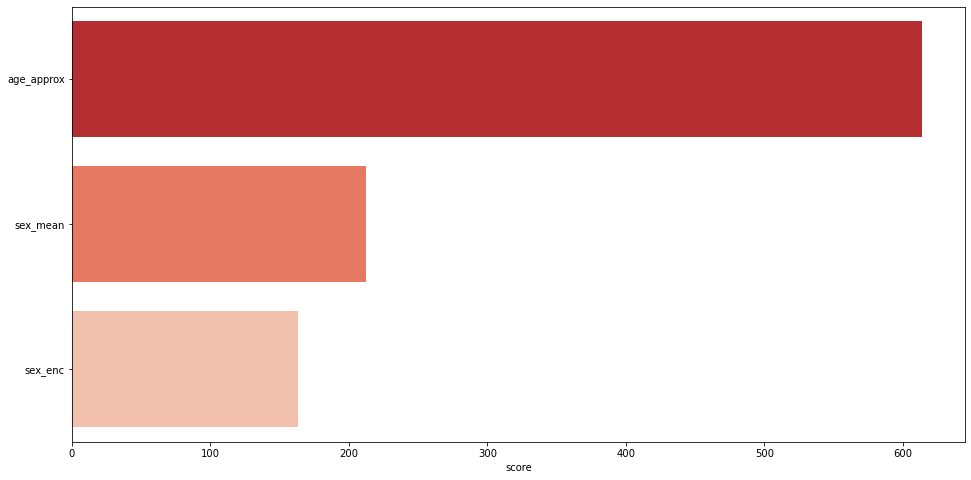

Fold: 2


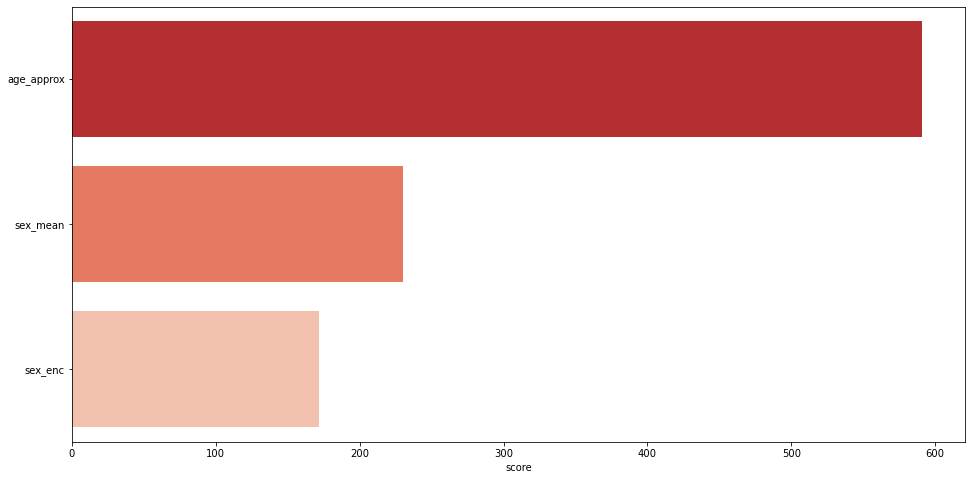

Fold: 3


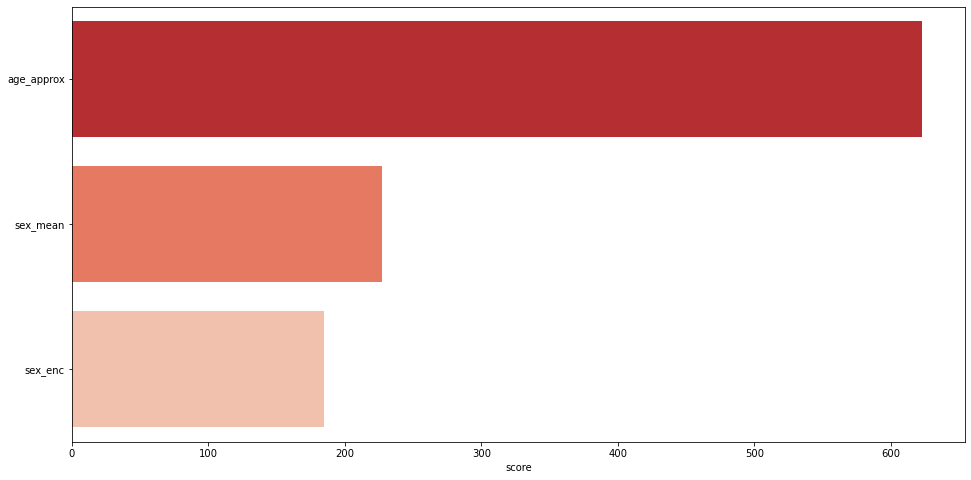

Fold: 4


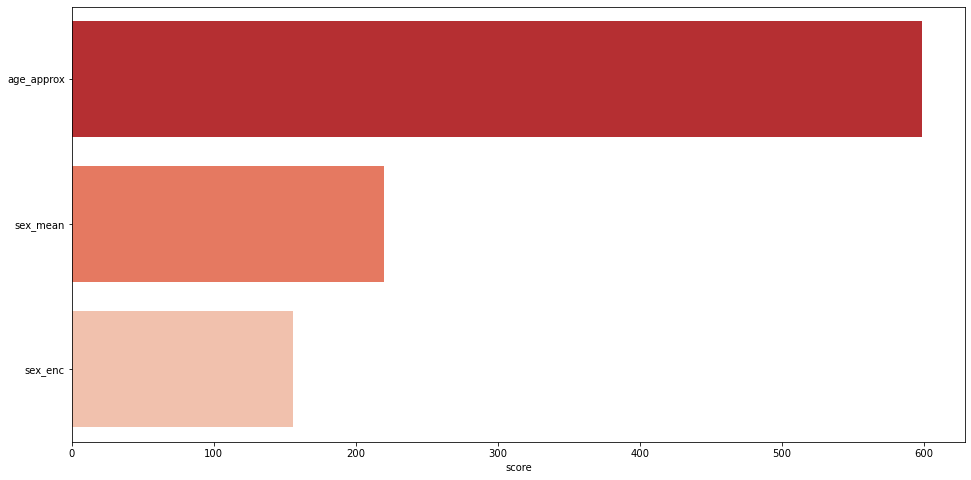

Fold: 5


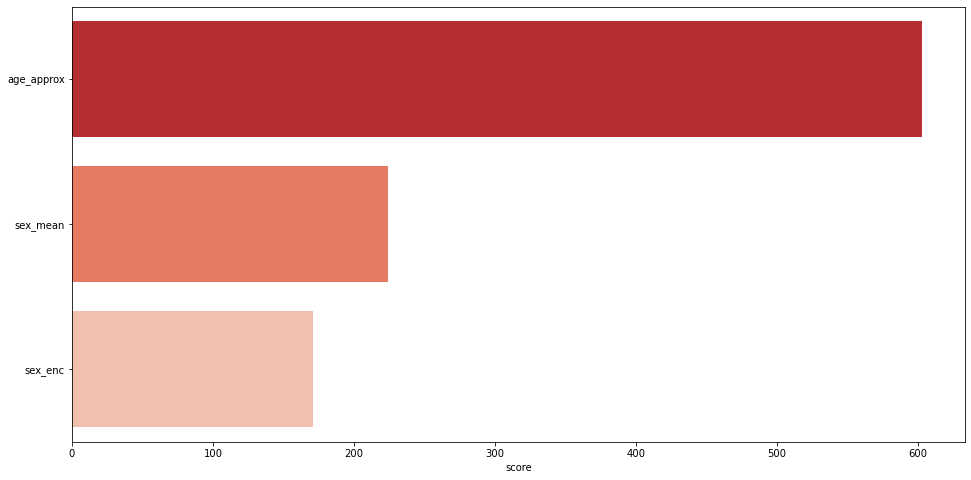

In [10]:
for n_fold, model in enumerate(model_list):
    print(f'Fold: {n_fold + 1}')
    feature_importance = model.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())

    importance = pd.DataFrame(data=values, index=keys,
                              columns=['score']).sort_values(by='score',
                                                             ascending=False)
    plt.figure(figsize=(16, 8))
    sns.barplot(x=importance.score.iloc[:20],
                y=importance.index[:20],
                orient='h',
                palette='Reds_r')

    plt.show()

# Model evaluation

In [11]:
display(evaluate_model(train, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(train, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.650260,0.683909,-0.033650,0.646695,0.683402,0.651737,0.680704,0.649942,0.681243,0.649753,0.688286,0.653171,0.685912
Accuracy,0.740959,0.890771,-0.149811,0.746273,0.901488,0.724526,0.872610,0.747772,0.900656,0.751066,0.898253,0.735161,0.880845
Precision,0.385151,0.225781,0.159370,0.395683,0.239024,0.368434,0.197671,0.390291,0.236857,0.401302,0.235450,0.370047,0.219904
Recall,0.198729,0.192391,0.006338,0.169434,0.165852,0.255691,0.248966,0.177103,0.149799,0.171121,0.162409,0.220295,0.234929
F1-score,0.259780,0.203824,0.055957,0.237268,0.195826,0.301879,0.220373,0.243646,0.183527,0.239932,0.192225,0.276177,0.227168
Support,5795.600000,2706.400000,3089.200000,5843.000000,2659.000000,5843.000000,2659.000000,5765.000000,2737.000000,5762.000000,2740.000000,5765.000000,2737.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.650260,0.683909,-0.033650,0.646695,0.683402,0.651737,0.680704,0.649942,0.681243,0.649753,0.688286,0.653171,0.685912
male,0.653412,0.678374,-0.024962,0.651420,0.681080,0.661493,0.663580,0.640709,0.681923,0.656853,0.680325,0.656584,0.684960
female,0.631597,0.674077,-0.042480,0.638663,0.664782,0.621240,0.684249,0.634725,0.667780,0.624717,0.685146,0.638641,0.668430
head/neck,0.589052,0.662546,-0.073494,0.582078,0.676200,0.596845,0.665016,0.592627,0.654283,0.586698,0.656733,0.587014,0.660501
upper extremity,0.632637,0.683693,-0.051056,0.622310,0.683644,0.639646,0.676007,0.624238,0.686393,0.633769,0.685816,0.643223,0.686607
lower extremity,0.623671,0.633628,-0.009956,0.615292,0.633175,0.628655,0.630181,0.617543,0.631066,0.620236,0.643946,0.636630,0.629769
torso,0.671572,0.681421,-0.009850,0.715441,0.672389,0.694615,0.672179,0.683557,0.680108,0.598180,0.700044,0.666066,0.682387
0 <= age < 26,0.576803,0.574510,0.002292,0.592407,0.574384,0.574351,0.564454,0.570851,0.591952,0.537311,0.559049,0.609093,0.582712
26 <= age < 40,0.501387,0.532451,-0.031064,0.501616,0.510738,0.519579,0.514631,0.507091,0.568694,0.460869,0.515672,0.517781,0.552522


# Adversarial Validation

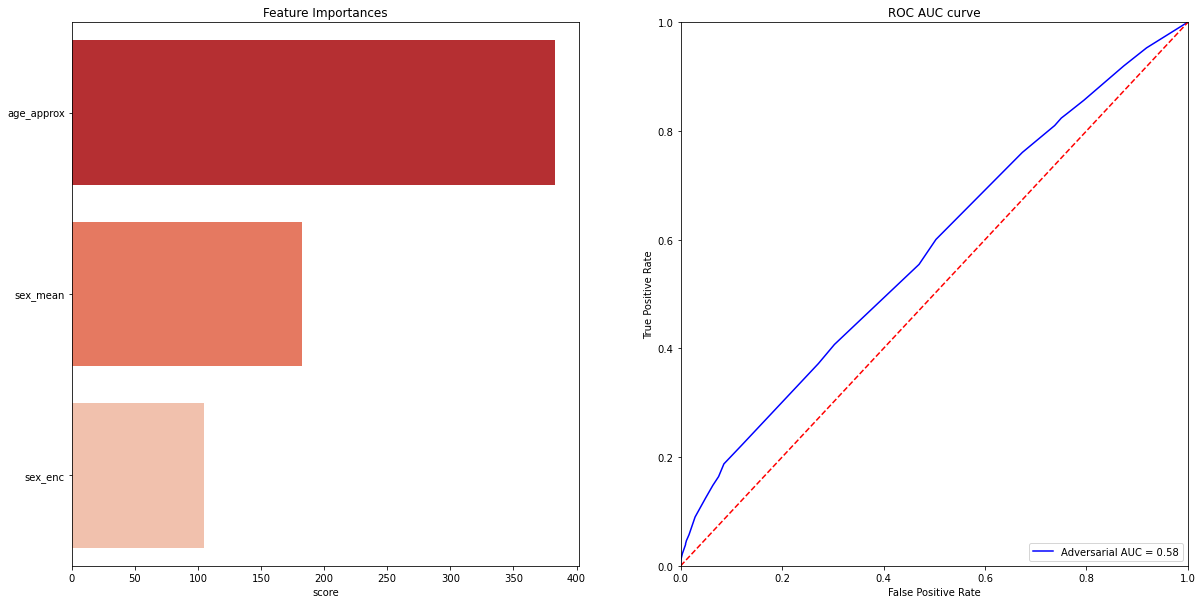

In [12]:
### Adversarial set
adv_train = train.copy()
adv_test = test.copy()
adv_train['dataset'] = 1
adv_test['dataset'] = 0

x_adv = pd.concat([adv_train, adv_test], axis=0)
y_adv = x_adv['dataset']

### Adversarial model
model_adv = XGBClassifier(**params, random_state=SEED)

model_adv.fit(x_adv[features], y_adv, eval_metric='auc', verbose=0)


### Preds
preds = model_adv.predict_proba(x_adv[features])[:, 1]


### Plot feature importance and ROC AUC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Feature importance
feature_importance = model_adv.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)

ax1.set_title('Feature Importances')
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r',
            ax=ax1)

# Plot ROC AUC curve
fpr_train, tpr_train, _ = roc_curve(y_adv, preds)
roc_auc_train = auc(fpr_train, tpr_train)

ax2.set_title('ROC AUC curve')
ax2.plot(fpr_train, tpr_train, color='blue', label='Adversarial AUC = %0.2f' % roc_auc_train)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

# Visualize predictions

In [13]:
train['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    train['pred'] += train[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(train[train['target'] > .5])}")
print(f"Train positive predictions: {len(train[train['pred'] > .5])}")
print(f"Train positive correct predictions: {len(train[(train['target'] > .5) & (train['pred'] > .5)])}")
    
print('Top 10 samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 8502
Train positive predictions: 4347
Train positive correct predictions: 1431
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.409171,0.313674,0.488871,0.377390,0.400558,0.465363
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.403026,0.286260,0.490127,0.374953,0.396865,0.466924
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.405317,0.286857,0.491369,0.379223,0.400620,0.468516
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.403026,0.286260,0.490127,0.374953,0.396865,0.466924
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.412364,0.307634,0.491369,0.383505,0.409755,0.469556
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.388494,0.260424,0.487246,0.354889,0.378599,0.461314
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.379495,0.245216,0.486464,0.345705,0.366199,0.453890
7,ISIC_0075663,female,35.0,torso,unknown,0,0.385126,0.258427,0.487246,0.349890,0.373541,0.456526
8,ISIC_0075914,male,30.0,torso,unknown,0,0.387501,0.275429,0.486464,0.345705,0.375491,0.454418
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.405317,0.286857,0.491369,0.379223,0.400620,0.468516


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.412364,0.307634,0.491369,0.383505,0.409755,0.469556
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.405317,0.286857,0.491369,0.379223,0.400620,0.468516
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.426226,0.346266,0.492289,0.400486,0.419110,0.472980
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.463569,0.424508,0.497862,0.451526,0.458121,0.485826
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.438530,0.360801,0.495051,0.424227,0.431048,0.481520
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.497867,0.499754,0.500282,0.495506,0.486776,0.507018
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.385126,0.258427,0.487246,0.349890,0.373541,0.456526
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.516624,0.537191,0.504682,0.521044,0.503544,0.516658
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.463569,0.424508,0.497862,0.451526,0.458121,0.485826
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.387501,0.275429,0.486464,0.345705,0.375491,0.454418


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
68,ISIC_0109568,male,80.0,lower extremity,unknown,0,0.516624,0.537191,0.504682,0.521044,0.503544,0.516658
75,ISIC_0114225,male,80.0,lower extremity,unknown,0,0.516624,0.537191,0.504682,0.521044,0.503544,0.516658
219,ISIC_0184482,female,85.0,torso,unknown,0,0.531820,0.567889,0.506449,0.536053,0.525161,0.523550
236,ISIC_0188926,male,80.0,torso,unknown,0,0.516624,0.537191,0.504682,0.521044,0.503544,0.516658
239,ISIC_0189333,female,85.0,head/neck,unknown,0,0.531820,0.567889,0.506449,0.536053,0.525161,0.523550
333,ISIC_0214335,male,80.0,head/neck,unknown,0,0.516624,0.537191,0.504682,0.521044,0.503544,0.516658
374,ISIC_0227038,male,80.0,torso,nevus,0,0.516624,0.537191,0.504682,0.521044,0.503544,0.516658
388,ISIC_0229832,female,85.0,torso,unknown,0,0.531820,0.567889,0.506449,0.536053,0.525161,0.523550
410,ISIC_0234248,female,80.0,torso,nevus,0,0.531543,0.558472,0.506449,0.540125,0.525607,0.527061
412,ISIC_0235728,male,85.0,head/neck,unknown,0,0.525899,0.564759,0.504682,0.530706,0.512140,0.517206


# Visualize test predictions

In [14]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 377|10605
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.472020,0.439922,0.497098,0.461510,0.466463,0.495106
1,ISIC_0052349,male,40.0,lower extremity,0.390457,0.271938,0.487246,0.352658,0.380485,0.459958
2,ISIC_0058510,female,55.0,torso,0.412364,0.307634,0.491369,0.383505,0.409755,0.469556
3,ISIC_0073313,female,50.0,torso,0.405317,0.286857,0.491369,0.379223,0.400620,0.468516
4,ISIC_0073502,female,45.0,lower extremity,0.403026,0.286260,0.490127,0.374953,0.396865,0.466924
5,ISIC_0074618,male,50.0,lower extremity,0.417726,0.328399,0.492289,0.386089,0.409912,0.471940
6,ISIC_0076801,male,45.0,upper extremity,0.409171,0.313674,0.488871,0.377390,0.400558,0.465363
7,ISIC_0077586,male,50.0,lower extremity,0.417726,0.328399,0.492289,0.386089,0.409912,0.471940
8,ISIC_0082004,female,45.0,torso,0.403026,0.286260,0.490127,0.374953,0.396865,0.466924
9,ISIC_0082785,male,65.0,lower extremity,0.463569,0.424508,0.497862,0.451526,0.458121,0.485826


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
31,ISIC_0131978,male,85.0,torso,0.525899,0.564759,0.504682,0.530706,0.512140,0.517206
36,ISIC_0148937,male,80.0,torso,0.516624,0.537191,0.504682,0.521044,0.503544,0.516658
56,ISIC_0169906,male,85.0,torso,0.525899,0.564759,0.504682,0.530706,0.512140,0.517206
69,ISIC_0182213,female,80.0,head/neck,0.531543,0.558472,0.506449,0.540125,0.525607,0.527061
88,ISIC_0197440,male,80.0,lower extremity,0.516624,0.537191,0.504682,0.521044,0.503544,0.516658
95,ISIC_0200120,female,85.0,torso,0.531820,0.567889,0.506449,0.536053,0.525161,0.523550
109,ISIC_0216447,male,80.0,head/neck,0.516624,0.537191,0.504682,0.521044,0.503544,0.516658
115,ISIC_0224309,female,85.0,upper extremity,0.531820,0.567889,0.506449,0.536053,0.525161,0.523550
140,ISIC_0244617,female,80.0,lower extremity,0.531543,0.558472,0.506449,0.540125,0.525607,0.527061
175,ISIC_0274789,male,80.0,torso,0.516624,0.537191,0.504682,0.521044,0.503544,0.516658


# Test set predictions

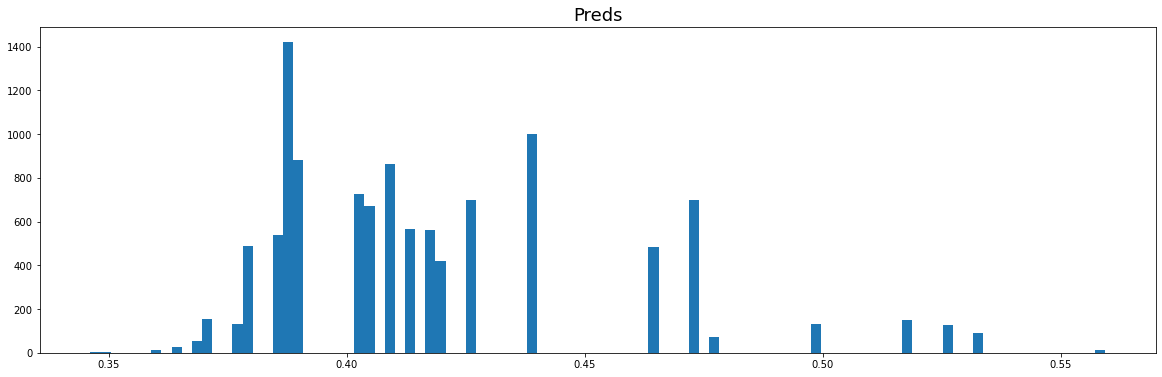

,image_name,target
0,ISIC_0052060,0.472020
1,ISIC_0052349,0.390457
2,ISIC_0058510,0.412364
3,ISIC_0073313,0.405317
4,ISIC_0073502,0.403026
5,ISIC_0074618,0.417726
6,ISIC_0076801,0.409171
7,ISIC_0077586,0.417726
8,ISIC_0082004,0.403026
9,ISIC_0082785,0.463569


,target
count,10982.000000
mean,0.417010
std,0.034944
min,0.346190
25%,0.388494
50%,0.409171
75%,0.438530
max,0.559221


In [15]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']

fig = plt.subplots(figsize=(20, 6))
plt.hist(submission['target'], bins=100)
plt.title('Preds', size=18)
plt.show()

display(submission.head(10))
display(submission.describe())

submission[['image_name', 'target']].to_csv('submission.csv', index=False)